# Multivariate Time Series Regression

So far, we have limited our modeling efforts to single time series. RNNs are naturally well suited to multivariate time series and represent a non-linear alternative to the Vector Autoregressive (VAR) models we covered in Chapter 8, Time Series Models. 

## Run inside docker container for GPU acceleration

See [tensorflow guide](https://www.tensorflow.org/install/docker) and more detailed [instructions](https://blog.sicara.com/tensorflow-gpu-opencv-jupyter-docker-10705b6cd1d)

`docker run -it -p 8889:8888 -v /path/to/machine-learning-for-trading/18_recurrent_neural_nets:/rnn --name tensorflow tensorflow/tensorflow:latest-gpu-py3 bash`

Inside docker container: 
`jupyter notebook --ip 0.0.0.0 --no-browser --allow-root`

## Imports & Settings

In [59]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
from datetime import datetime, date
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import minmax_scale
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, concatenate, Embedding, Reshape
import keras
import keras.backend as K
import tensorflow as tf

In [2]:
sns.set_style('whitegrid')
np.random.seed(42)
K.clear_session()

## Load Data

For comparison, we illustrate the application of RNNs to modeling and forecasting several time series using the same dataset we used for the VAR example, monthly data on consumer sentiment, and industrial production from the Federal Reserve's FRED service in Chapter 8, Time Series Models:

In [3]:
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1980', '2017-12').dropna()
df.columns = ['sentiment', 'ip']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 456 entries, 1980-01-01 to 2017-12-01
Data columns (total 2 columns):
sentiment    456 non-null float64
ip           456 non-null float64
dtypes: float64(2)
memory usage: 10.7 KB


In [4]:
df['1980':].head()

,sentiment,ip
DATE,,
1980-01-01,67.0,46.8853
1980-02-01,66.9,47.9806
1980-03-01,56.5,48.4758
1980-04-01,52.7,47.0631
1980-05-01,51.7,45.6939


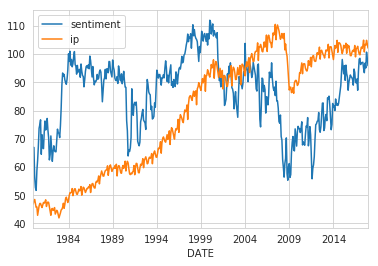

In [5]:
df.plot();

## Prepare Data

### Scaling

First we scale the data to the [0,1] interval:

In [6]:
df_scaled = df.apply(minmax_scale)

### Stationarity

We apply the same transformation—annual difference for both series, prior log-transform for industrial production—to achieve stationarity that we used in Chapter 8 on Time Series Models:

In [35]:
df_transformed = pd.DataFrame({'ip': np.log(df.ip).diff(12),
                              'sentiment': df.sentiment.diff(12)}).dropna()

We can reshape directly to get non-overlapping series, i.e., one sample for each year (works only if the number of samples is divisible by window size):

In [7]:
df_scaled.values.reshape(-1, 12, 2).shape

(38, 12, 2)

### Reshape data into RNN format

The create_multivariate_rnn_data function transforms a dataset of several time series into the shape required by the Keras RNN layers, namely `n_samples` x `window_size` x `n_series`, as follows:

In [9]:
def create_multivariate_rnn_data(data, window_size):
    y = data[window_size:]
    n = data.shape[0]
    X = np.stack([data[i: j] for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y

We will use window_size of 24 months and obtain the desired inputs for our RNN model, as follows:

In [8]:
window_size = 24

In [36]:
X, y = create_multivariate_rnn_data(df_transformed, window_size=window_size)

In [37]:
X.shape, y.shape

((420, 24, 2), (420, 2))

Finally, we split our data into a train and a test set, using the last 24 months to test the out-of-sample performance, as shown here:

In [38]:
test_size =24
train_size = X.shape[0]-test_size

In [39]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [40]:
X_train.shape, X_test.shape

((396, 24, 2), (24, 24, 2))

## Define Model Architecture

We use a similar architecture with two stacked LSTM layers with 12 and 6 units, respectively, followed by a fully-connected layer with 10 units. The output layer has two units, one for each time series. We compile them using mean absolute loss and the recommended RMSProp optimizer, as follows:

In [70]:
n_features = output_size = 2

In [71]:
lstm1_units = 12
lstm2_units = 6

In [72]:
rnn = Sequential([
    LSTM(units=lstm1_units,
         dropout=.2,
         recurrent_dropout=.2,
         input_shape=(window_size, n_features), name='LSTM1',
         return_sequences=True),
    LSTM(units=lstm2_units,
         dropout=.2,
         recurrent_dropout=.2,
         name='LSTM2'),
    Dense(10, name='FC1'),
    Dense(output_size, name='Output')
])

The model has 1,268 parameters, as shown here:

In [73]:
rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM1 (LSTM)                 (None, 24, 12)            720       
_________________________________________________________________
LSTM2 (LSTM)                 (None, 6)                 456       
_________________________________________________________________
FC1 (Dense)                  (None, 10)                70        
_________________________________________________________________
Output (Dense)               (None, 2)                 22        
Total params: 1,268
Trainable params: 1,268
Non-trainable params: 0
_________________________________________________________________


In [45]:
rnn.compile(loss='mae', optimizer='RMSProp')

## Train the Model

We train for 50 epochs with a batch_size value of 20 using early stopping:

In [46]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=5,
                              restore_best_weights=True)

In [47]:
rnn_path = 'models/fred.lstm_{}_{}.weights.best.hdf5'.format(lstm1_units, lstm2_units)
checkpointer = ModelCheckpoint(filepath=rnn_path,
                              monitor='val_loss',
                              save_best_only=True,
                              save_weights_only=True,
                              period=5)

In [50]:
result = rnn.fit(X_train,
                 y_train,
                 epochs=50,
                 batch_size=20,
                 validation_data=(X_test, y_test),
                 callbacks=[checkpointer, early_stopping],
                 verbose=1)

Train on 396 samples, validate on 24 samples
Epoch 1/50
396/396 [==============================] - 2s 5ms/step - loss: 3.8474 - val_loss: 2.2458
Epoch 2/50
396/396 [==============================] - 1s 2ms/step - loss: 3.8011 - val_loss: 2.2199
Epoch 3/50
396/396 [==============================] - 1s 2ms/step - loss: 3.7493 - val_loss: 2.1867
Epoch 4/50
396/396 [==============================] - 1s 2ms/step - loss: 3.7158 - val_loss: 2.1477
Epoch 5/50
396/396 [==============================] - 1s 2ms/step - loss: 3.6758 - val_loss: 2.0966
Epoch 6/50
396/396 [==============================] - 1s 2ms/step - loss: 3.6266 - val_loss: 2.0551
Epoch 7/50
396/396 [==============================] - 1s 2ms/step - loss: 3.5552 - val_loss: 2.0113
Epoch 8/50
396/396 [==============================] - 1s 2ms/step - loss: 3.4837 - val_loss: 1.9549
Epoch 9/50
396/396 [==============================] - 1s 2ms/step - loss: 3.4383 - val_loss: 1.9126
Epoch 10/50
396/396 [==============================] - 

## Evaluate the Results

Training stops early after 25 epochs, yielding a test MAE of 1.71, which compares favorably to the test MAE for the VAR model of 1.91.

However, the two results are not fully comparable because the RNN model produces 24 one-step-ahead forecasts, whereas the VAR model uses its own predictions as input for its out-of-sample forecast. You may want to tweak the VAR setup to obtain comparable forecasts and compare their performance:

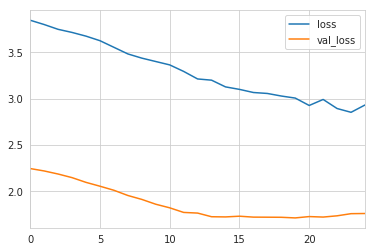

In [51]:
pd.DataFrame(result.history).plot();

In [52]:
y_pred = pd.DataFrame(rnn.predict(X_test), columns=y_test.columns, index=y_test.index)
y_pred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 2016-01-01 to 2017-12-01
Data columns (total 2 columns):
ip           24 non-null float32
sentiment    24 non-null float32
dtypes: float32(2)
memory usage: 384.0 bytes


In [65]:
test_mae = mean_absolute_error(y_pred, y_test)

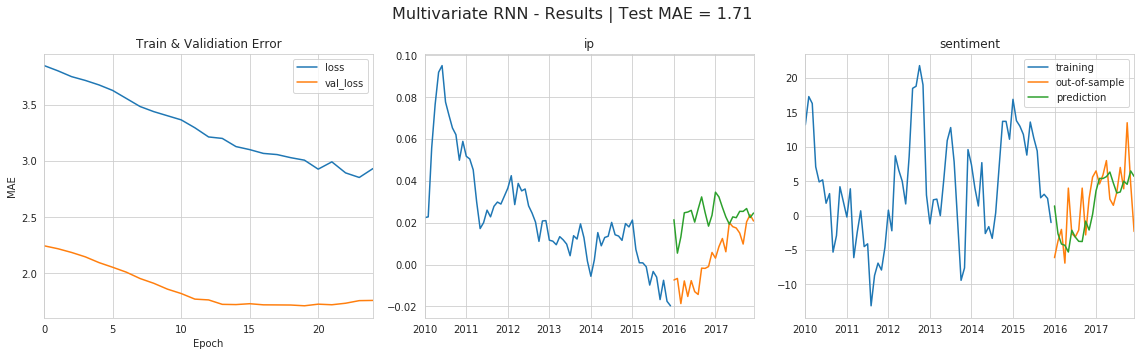

In [69]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 5))
pd.DataFrame(result.history).plot(ax=axes[0], title='Train & Validiation Error')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MAE')
for i, col in enumerate(y_test.columns, 1):
    y_train.loc['2010':, col].plot(ax=axes[i], label='training', title=col)
    y_test[col].plot(ax=axes[i], label='out-of-sample')
    y_pred[col].plot(ax=axes[i], label='prediction')
    axes[i].set_xlabel('')
plt.legend()
fig.suptitle('Multivariate RNN - Results | Test MAE = {:.2f}'.format(test_mae), fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig('figures/multivariate_results', dpi=300);